In [1]:
!mkdir genres && wget http://opihi.cs.uvic.ca/sound/genres.tar.gz && tar -xf genres.tar.gz genres/

--2020-06-26 11:25:26--  http://opihi.cs.uvic.ca/sound/genres.tar.gz
Resolving opihi.cs.uvic.ca (opihi.cs.uvic.ca)... 142.104.68.135
Connecting to opihi.cs.uvic.ca (opihi.cs.uvic.ca)|142.104.68.135|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1225571541 (1.1G) [application/x-gzip]
Saving to: ‘genres.tar.gz’

genres.tar.gz       100%[===================>]   1.14G   804KB/s    in 25m 27s 

2020-06-26 11:50:53 (784 KB/s) - ‘genres.tar.gz’ saved [1225571541/1225571541]



In [2]:
pip install torchaudio

     |████████████████████████████████| 3.2MB 14.5MB/s 


In [3]:
import torch
import torchvision
import torchaudio
import random
import numpy as np
import librosa
import librosa.display
import pandas as pd
import os
from PIL import Image
import pathlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline
from tqdm.autonotebook import tqdm
import IPython.display as ipd
import torchvision.transforms as T

In [4]:
data_path = '/content/genres/'

In [5]:
cmap = plt.get_cmap('inferno')
plt.figure(figsize=(8,8))
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:
    pathlib.Path(f'img_data/{g}').mkdir(parents=True, exist_ok=True)
    for filename in os.listdir(f'{data_path}/{g}'):
        songname = f'{data_path}/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=5)
        plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB');
        plt.axis('off');
        plt.savefig(f'img_data/{g}/{filename[:-3].replace(".", "")}.png')
        plt.clf()

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


<Figure size 576x576 with 0 Axes>

In [6]:
img_path = 'img_data'

In [257]:
batch_size = 8
image_size = 224

In [258]:
train_trms = T.Compose([
                        T.Resize(image_size),
                        T.RandomRotation(20),
                        T.RandomHorizontalFlip(),
                        T.ToTensor()
                        ])
val_trms = T.Compose([
                        T.Resize(image_size),
                        T.ToTensor()
                        ])

In [259]:
train_data = torchvision.datasets.ImageFolder(root = img_path, transform = train_trms)
val_data = torchvision.datasets.ImageFolder(root = img_path, transform = val_trms)

In [260]:
def Encode(data):
    classes = data.classes
    encoder = {}
    for i in range(len(classes)):
        encoder[i] = classes[i]
    return encoder

def Decoder(data):
    classes = data.classes
    
    decoder = {}
    for i in range(len(classes)):
        decoder[classes[i]] = i
    return decoder

In [261]:
def class_plot(data,n_figures = 12):
    n_row = int(n_figures/4)
    fig,axes = plt.subplots(figsize=(14, 10), nrows = n_row, ncols=4)
    for ax in axes.flatten():
        a = random.randint(0,len(data))
        (image,label) = data[a]
#         print(type(image))
        label = int(label)
        encoder = Encode(data)
        l = encoder[label]
       
        image = image.numpy().transpose(1,2,0)
        im = ax.imshow(image)
        ax.set_title(l)
        ax.axis('off')
    plt.show()

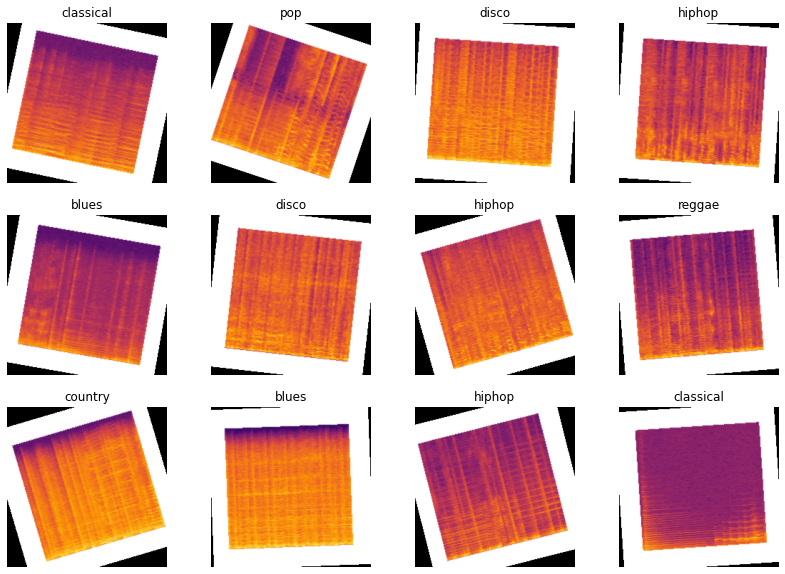

In [262]:
class_plot(train_data)

In [263]:
torch.manual_seed(43)
val_size = int(len(train_data)*0.1)
train_size = len(train_data) - val_size

In [264]:
from torch.utils.data import random_split
train_ds, val_ds = random_split(train_data, [train_size,val_size])
len(train_ds), len(val_ds)

(900, 100)

In [265]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

images.shape: torch.Size([8, 3, 224, 224])


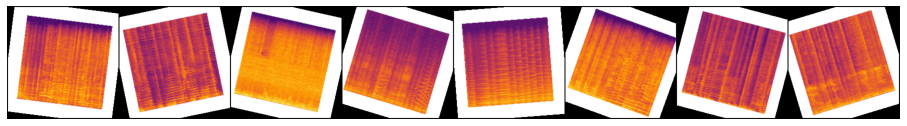

In [266]:
for images, _ in train_dl:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [267]:
def accuracy(outputs, labels):
  _,preds = torch.max(outputs,dim=1)
  return torch.tensor(torch.sum(preds == labels).item()/len(preds))

In [268]:
class MultilabelImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)                      
        loss = F.cross_entropy(out, targets)      
        return loss
    
    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)                           # Generate predictions
        loss = F.cross_entropy(out, targets)  # Calculate loss
        score = accuracy(out, targets)
        return {'val_loss': loss.detach(), 'val_score': score.detach() }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['val_loss'], result['val_score']))

In [269]:
class Net1(MultilabelImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),

            nn.Flatten(), 
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
            
        )
        
    def forward(self, xb):
        return self.network(xb)

In [270]:
import torchvision.models as models
class Net(MultilabelImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 10)
    
    def forward(self, xb):
        return self.network(xb)
    def freeze(self):
      for param in self.network.parameters():
        param.require_grad = False
      for param in self.network.fc.parameters():
        param.require_grad = True
    
    def unfreeze(self):
      for param in self.network.parameters():
        param.require_grad = True

In [271]:
Net()

Net(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

In [272]:
def evaluate(model,val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [296]:
@torch.no_grad()
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            loss.backward()
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            optimizer.zero_grad()
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        # Validation phase
        result = evaluate(model, val_loader)
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [297]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [298]:
device = get_default_device()
device

device(type='cuda')

In [299]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [300]:
model = to_device(Net(), device)

In [301]:
torch.cuda.empty_cache()

In [302]:
history = [evaluate(model, val_dl)]

In [303]:
model.freeze()

In [304]:
epochs = 5
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [305]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)


Epoch [0], val_loss: 2.1213, val_score: 0.2768



Epoch [1], val_loss: 1.8408, val_score: 0.3036



Epoch [2], val_loss: 1.5610, val_score: 0.5536



Epoch [3], val_loss: 1.4661, val_score: 0.4196



Epoch [4], val_loss: 1.3573, val_score: 0.4821
CPU times: user 25 s, sys: 2.44 s, total: 27.4 s
Wall time: 1min 8s


In [306]:
%%time
history += fit_one_cycle(15, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)


Epoch [0], val_loss: 1.4131, val_score: 0.4464



Epoch [1], val_loss: 1.4799, val_score: 0.5000



Epoch [2], val_loss: 1.8310, val_score: 0.3482



Epoch [3], val_loss: 1.6751, val_score: 0.4196



Epoch [4], val_loss: 1.5961, val_score: 0.3929



Epoch [5], val_loss: 1.4679, val_score: 0.4732



Epoch [6], val_loss: 1.3878, val_score: 0.5179



Epoch [7], val_loss: 1.3280, val_score: 0.5089



Epoch [8], val_loss: 1.1580, val_score: 0.6161



Epoch [9], val_loss: 1.2070, val_score: 0.5625



Epoch [10], val_loss: 0.9571, val_score: 0.6518



Epoch [11], val_loss: 1.0473, val_score: 0.6696



Epoch [12], val_loss: 0.8890, val_score: 0.7321



Epoch [13], val_loss: 0.9805, val_score: 0.6696



Epoch [14], val_loss: 0.9966, val_score: 0.6875
CPU times: user 1min 14s, sys: 7.18 s, total: 1min 22s
Wall time: 3min 26s


In [307]:
model.unfreeze()

In [308]:
%%time
history += fit_one_cycle(50, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)


Epoch [0], val_loss: 0.9922, val_score: 0.6964



Epoch [1], val_loss: 0.9522, val_score: 0.6964



Epoch [2], val_loss: 1.0757, val_score: 0.6786



Epoch [3], val_loss: 1.1295, val_score: 0.6696



Epoch [4], val_loss: 1.1033, val_score: 0.6518



Epoch [5], val_loss: 1.1969, val_score: 0.5982



Epoch [6], val_loss: 1.0509, val_score: 0.6339



Epoch [7], val_loss: 1.2199, val_score: 0.6071



Epoch [8], val_loss: 1.0686, val_score: 0.5982



Epoch [9], val_loss: 1.3248, val_score: 0.5893



Epoch [10], val_loss: 1.2026, val_score: 0.5714



Epoch [11], val_loss: 1.0613, val_score: 0.6161



Epoch [12], val_loss: 1.1433, val_score: 0.5893



Epoch [13], val_loss: 1.2084, val_score: 0.5357



Epoch [14], val_loss: 1.2866, val_score: 0.4821



Epoch [15], val_loss: 1.1743, val_score: 0.6250



Epoch [16], val_loss: 1.1978, val_score: 0.6250



Epoch [17], val_loss: 1.1624, val_score: 0.6339



Epoch [18], val_loss: 1.1862, val_score: 0.6071



Epoch [19], val_loss: 1.0106, val_score: 0.7321



Epoch [20], val_loss: 1.4128, val_score: 0.6071



Epoch [21], val_loss: 1.1567, val_score: 0.7054



Epoch [22], val_loss: 1.0685, val_score: 0.7321



Epoch [23], val_loss: 1.3032, val_score: 0.5893



Epoch [24], val_loss: 1.4048, val_score: 0.6250



Epoch [25], val_loss: 1.1829, val_score: 0.6518



Epoch [26], val_loss: 1.1742, val_score: 0.6429



Epoch [27], val_loss: 1.1785, val_score: 0.6786



Epoch [28], val_loss: 1.4624, val_score: 0.5625



Epoch [29], val_loss: 1.2937, val_score: 0.6071



Epoch [30], val_loss: 1.3095, val_score: 0.6161



Epoch [31], val_loss: 1.1918, val_score: 0.6429



Epoch [32], val_loss: 1.2770, val_score: 0.6339



Epoch [33], val_loss: 1.2388, val_score: 0.6696



Epoch [34], val_loss: 1.3583, val_score: 0.6696



Epoch [35], val_loss: 1.2438, val_score: 0.6518



Epoch [36], val_loss: 1.2251, val_score: 0.6607



Epoch [37], val_loss: 1.3324, val_score: 0.6964



Epoch [38], val_loss: 1.3052, val_score: 0.6964



Epoch [39], val_loss: 1.3163, val_score: 0.6696



Epoch [40], val_loss: 1.2582, val_score: 0.6964



Epoch [41], val_loss: 1.5474, val_score: 0.6607



Epoch [42], val_loss: 1.4248, val_score: 0.6607



Epoch [43], val_loss: 1.3377, val_score: 0.7054



Epoch [44], val_loss: 1.2840, val_score: 0.7589



Epoch [45], val_loss: 1.2667, val_score: 0.7232



Epoch [46], val_loss: 1.2806, val_score: 0.7321



Epoch [47], val_loss: 1.2970, val_score: 0.6696



Epoch [48], val_loss: 1.3481, val_score: 0.7143



Epoch [49], val_loss: 1.4432, val_score: 0.6786
CPU times: user 4min 11s, sys: 24.1 s, total: 4min 36s
Wall time: 11min 36s


In [309]:
%%time
history += fit_one_cycle(100, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)


Epoch [0], val_loss: 1.3134, val_score: 0.7411



Epoch [1], val_loss: 1.4207, val_score: 0.7054



Epoch [2], val_loss: 1.3749, val_score: 0.7500



Epoch [3], val_loss: 1.4043, val_score: 0.7143



Epoch [4], val_loss: 1.6280, val_score: 0.6696



Epoch [5], val_loss: 1.5598, val_score: 0.6786



Epoch [6], val_loss: 1.3442, val_score: 0.7054



Epoch [7], val_loss: 1.2984, val_score: 0.6964



Epoch [8], val_loss: 1.2927, val_score: 0.7500



Epoch [9], val_loss: 1.7022, val_score: 0.6786



Epoch [10], val_loss: 1.4593, val_score: 0.6071



Epoch [11], val_loss: 1.0452, val_score: 0.7321



Epoch [12], val_loss: 1.3505, val_score: 0.6696



Epoch [13], val_loss: 1.3804, val_score: 0.7054



Epoch [14], val_loss: 1.3014, val_score: 0.6964



Epoch [15], val_loss: 1.2435, val_score: 0.6696



Epoch [16], val_loss: 1.2775, val_score: 0.6696



Epoch [17], val_loss: 1.2403, val_score: 0.6161



Epoch [18], val_loss: 1.6008, val_score: 0.6696



Epoch [19], val_loss: 1.1719, val_score: 0.6964



Epoch [20], val_loss: 1.4445, val_score: 0.6339



Epoch [21], val_loss: 1.5722, val_score: 0.6071



Epoch [22], val_loss: 1.1578, val_score: 0.6518



Epoch [23], val_loss: 1.5207, val_score: 0.6518



Epoch [24], val_loss: 1.5508, val_score: 0.6339



Epoch [25], val_loss: 1.6442, val_score: 0.6429



Epoch [26], val_loss: 1.5829, val_score: 0.5625



Epoch [27], val_loss: 1.1066, val_score: 0.7143



Epoch [28], val_loss: 1.5679, val_score: 0.6607



Epoch [29], val_loss: 1.4636, val_score: 0.6875



Epoch [30], val_loss: 1.5426, val_score: 0.6161



Epoch [31], val_loss: 1.4341, val_score: 0.6339



Epoch [32], val_loss: 1.3666, val_score: 0.6518



Epoch [33], val_loss: 1.3389, val_score: 0.6696



Epoch [34], val_loss: 1.3586, val_score: 0.6518



Epoch [35], val_loss: 1.7362, val_score: 0.5446



Epoch [36], val_loss: 1.1854, val_score: 0.6429



Epoch [37], val_loss: 1.3496, val_score: 0.6339



Epoch [38], val_loss: 1.0929, val_score: 0.7232



Epoch [39], val_loss: 1.3403, val_score: 0.6429



Epoch [40], val_loss: 1.4807, val_score: 0.6339



Epoch [41], val_loss: 1.2647, val_score: 0.6429



Epoch [42], val_loss: 1.5180, val_score: 0.6518



Epoch [43], val_loss: 1.4019, val_score: 0.6339



Epoch [44], val_loss: 1.3976, val_score: 0.6964



Epoch [45], val_loss: 1.6360, val_score: 0.6518



Epoch [46], val_loss: 1.2783, val_score: 0.6696



Epoch [47], val_loss: 1.3785, val_score: 0.6518



Epoch [48], val_loss: 1.4872, val_score: 0.6964



Epoch [49], val_loss: 1.3883, val_score: 0.6339



Epoch [50], val_loss: 1.5854, val_score: 0.6339



Epoch [51], val_loss: 1.3023, val_score: 0.6696



Epoch [52], val_loss: 1.6565, val_score: 0.6339



Epoch [53], val_loss: 1.7235, val_score: 0.6161



Epoch [54], val_loss: 1.4182, val_score: 0.6518



Epoch [55], val_loss: 1.6559, val_score: 0.6429



Epoch [56], val_loss: 1.6981, val_score: 0.5804



Epoch [57], val_loss: 1.4591, val_score: 0.6607



Epoch [58], val_loss: 1.6727, val_score: 0.6786



Epoch [59], val_loss: 1.3661, val_score: 0.6518



Epoch [60], val_loss: 1.4438, val_score: 0.7054



Epoch [61], val_loss: 1.4239, val_score: 0.6607



Epoch [62], val_loss: 1.6430, val_score: 0.6518



Epoch [63], val_loss: 1.4529, val_score: 0.6786



Epoch [64], val_loss: 1.5342, val_score: 0.6607



Epoch [65], val_loss: 1.4708, val_score: 0.6607



Epoch [66], val_loss: 1.5733, val_score: 0.7232



Epoch [67], val_loss: 1.5247, val_score: 0.6429



Epoch [68], val_loss: 1.6964, val_score: 0.6964



Epoch [69], val_loss: 1.7774, val_score: 0.6875



Epoch [70], val_loss: 1.4467, val_score: 0.7054



Epoch [71], val_loss: 1.5806, val_score: 0.6875



Epoch [72], val_loss: 1.4560, val_score: 0.6696



Epoch [73], val_loss: 1.5047, val_score: 0.7232



Epoch [74], val_loss: 1.6790, val_score: 0.6518



Epoch [75], val_loss: 1.7165, val_score: 0.6429



Epoch [76], val_loss: 1.7887, val_score: 0.6786



Epoch [77], val_loss: 1.5923, val_score: 0.6696



Epoch [78], val_loss: 1.8719, val_score: 0.6786



Epoch [79], val_loss: 1.7298, val_score: 0.6429



Epoch [80], val_loss: 1.6606, val_score: 0.7054



Epoch [81], val_loss: 1.9560, val_score: 0.6518



Epoch [82], val_loss: 1.8855, val_score: 0.6518



Epoch [83], val_loss: 1.3185, val_score: 0.7232



Epoch [84], val_loss: 1.6937, val_score: 0.7143



Epoch [85], val_loss: 1.4501, val_score: 0.6964



Epoch [86], val_loss: 1.6924, val_score: 0.6964



Epoch [87], val_loss: 1.6227, val_score: 0.7411



Epoch [88], val_loss: 1.6114, val_score: 0.7411



Epoch [89], val_loss: 1.5936, val_score: 0.7232



Epoch [90], val_loss: 1.5360, val_score: 0.7143



Epoch [91], val_loss: 1.7898, val_score: 0.7054



Epoch [92], val_loss: 1.4364, val_score: 0.6964



Epoch [93], val_loss: 1.8139, val_score: 0.7232



Epoch [94], val_loss: 1.8082, val_score: 0.7054



Epoch [95], val_loss: 1.5442, val_score: 0.7054



Epoch [96], val_loss: 1.6904, val_score: 0.6964



Epoch [97], val_loss: 1.5418, val_score: 0.7232



Epoch [98], val_loss: 1.5139, val_score: 0.7679



Epoch [99], val_loss: 1.6785, val_score: 0.7411
CPU times: user 8min 20s, sys: 48.3 s, total: 9min 9s
Wall time: 22min 57s


In [ ]:
torch.save(model.state_dict(), '/content/model.pth')